# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate (mat. 2095665), Sana Amiri Manesh(mat. 2061496)
---

## Project 1 - Car classification
## Project Overview

The goal of this project is to develop an optimal classifier for accurately recognizing car makes.  
To achieve this, we use the CompCars dataset as the starting point.  

The dataset provides both a `train_test_split` file, which defines the division between training and test sets, and bounding box annotations that delimit the cars within the images.

### Import libraries and set seeds for proper results replication

In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import scipy.io
## Torchvision
import torchvision   # For Computer Vision tasks
import torchvision.transforms as transforms   # Transforms for images for data augmentation
from PIL import Image

from torch.utils.data import Dataset, DataLoader

from collections import Counter # For counting values in a list
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score

# Path to the folder where the datasets are/should be downloaded
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
generator = torch.Generator().manual_seed(seed) # For explicit splitting and/or shuffling

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

We then use the labels assigned to each image, which contain the bounding box, to crop the images accordingly.  
NOTE:this process can take 10-15 min

In [2]:
# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

#Given an image and a bounding box, crops the image to the bounding box
def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

#Saves the cropped images to the output directory
def save_cropped_images(file_list, output_dir):
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')

				# Given the values of labels path, put the correct car make, model and year in the output directory
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)

				# Load the image
				image = Image.open(image_path).convert("RGB")

				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)

				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

#Given a mat file and labels, returns the make and model names
def get_names(mat_file, labels):
	mat_data = scipy.io.loadmat(mat_file)
	make_names = mat_data['make_names']
	model_names = mat_data['model_names']
	make_name = make_names[int(labels[0]) - 1][0].item()
	model_name = model_names[int(labels[1]) - 1][0].item()
	return make_name, model_name

#Save the cropped images to the output directory
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_val_path = os.path.join(class_dir, "train_val")
test_path = os.path.join(class_dir, "test")

print("test", test_path)
print("train", train_val_path)
save_cropped_images(train_list, train_val_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train_val


### Cropped Dataset
Now that the images are cropped, we can load them into the data loader.  
We save for each image the `car_make` and `car_model` labels in order to train the classificator and apply the transformation `transform` if any

In [3]:
#### DATASET FOR CROPPED IMAGES ####

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

		# Save the labels
        self.car_make = []
        self.car_model = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-2]  # Car make, model
            #Get labels from the image path, append them to the lists, and convert them to tensors of type long
            self.car_make.append(int(label[0]))
            self.car_model.append(int(label[1]))

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        car_make = self.car_make[index]
        car_model = self.car_model[index]

        if self.transform:
            image = self.transform(image)

        return image, car_make, car_model

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


## PREPROCESSING

### Calculating the mean and std  
To normalize the data in the train, validation, and test sets, I first need to compute the mean and standard deviation of the training set.  

In [4]:
def calculate_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)

    # Initialize total_sum and total_sum_squares with the correct shape
    total_sum = torch.zeros(3)
    total_sum_squares = torch.zeros(3)
    total_samples = 0

    for images, _, _ in tqdm(loader):  # Assume the dataset returns (image, label)
        # Convert images to float tensors
        images = images.float()
        batch_samples = images.size(0)  # Number of images in the batch
        total_samples += batch_samples

        # Sum over batch, height, width (keeping channels)
        total_sum += images.sum(dim=[0, 2, 3])
        total_sum_squares += (images ** 2).sum(dim=[0, 2, 3])

    # Calculate mean and std
    total_pixels = total_samples * images.size(2) * images.size(3)
    mean = total_sum / total_pixels
    std = torch.sqrt((total_sum_squares / total_pixels) - mean.pow(2))

    return mean, std

# Create the dataset
to_tensor_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor()
])

### Splitting the dataset in training, validation and test set

In [5]:
# Path to the folder where the datasets are/should be downloaded
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")

# Create the datasets
train_val_dataset = CroppedCarDataset(image_dir=train_val_path, transform=to_tensor_train) #dataset that contains train and validation datasets
train_len = int(0.7*len(train_val_dataset))  # 70% training
val_len = len(train_val_dataset) - train_len	# 30% validation

train_dataset, val_dataset = data.random_split(train_val_dataset, [train_len, val_len], generator=generator) #split the dataset into train and validation datasets

mean, std = calculate_mean_std(train_dataset) #calculate the mean and standard deviation of the training dataset
print("Mean:", mean)
print("Std:", std)

  0%|          | 0/176 [00:00<?, ?it/s]

Mean: tensor([0.4262, 0.4063, 0.4067])
Std: tensor([0.2833, 0.2797, 0.2832])


## Transformations
In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [6]:
from torchvision.transforms import RandomAffine, RandomHorizontalFlip

# # If you have already calculated the mean and standard deviation, you can directly assign them here
# mean = [0.4262, 0.4063, 0.4067]
# std = [0.2833, 0.2797, 0.2832]

##### TRANSFORMS #####
base_transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean, std)
])

transform1 = transforms.Compose([
	RandomAffine((0.05, 0.05)),
	torchvision.transforms.RandomApply(
		[torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)],
		p=0.5), # Color distorsion
  	RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(10),
    #transforms.RandomCrop(224, padding=4),
    #torchvision.transforms.RandomGrayscale(p=0.2), # Random grayscale
	#torchvision.transforms.GaussianBlur(kernel_size=9), # Gaussian blur
	transforms.Normalize(mean, std),
])

augmentation_transforms = transforms.Compose([
	RandomAffine((0.05, 0.05)),
	transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
  	RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
])

transform2 = transforms.Compose([
				transforms.Normalize(mean, std),
                transforms.RandomRotation(10),
				#transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
				])

normalize = transforms.Compose([
	transforms.Normalize(mean, std)
])

In [7]:
test_dataset = CroppedCarDataset(image_dir=test_path, transform=base_transform)   #dataset that contains test dataset

### Data Augmentation  
Let's see if the dataset is not balanced

In [8]:
# Augment the training dataset
class AugmentedDataset(Dataset):
    def __init__(self, dataset, target_class, num_new_samples, augment_transform, base_transform=None):
        self.dataset = dataset
        self.target_class = target_class
        self.num_new_samples = num_new_samples
        self.base_transform = base_transform
        self.augment_transform = augment_transform
        self.imgs = []
        self.make = []
        self.model = []
        self.augmented_indices = []

        for (img, make, model) in tqdm(self.dataset):
            self.imgs.append(img)
            self.make.append(make)
            self.model.append(model)

        for target in self.target_class:
            # Augment the target class
            self.augment_target_class(target)

	#Find the indices of the target class and add the indices to the augmented_indices list
    def augment_target_class(self, target):
        target_indices = [i for i, make in enumerate(self.make) if make == target] #get the indices of the target class
        num_existing_samples = len(target_indices)
        if num_existing_samples == 0:
            print("No samples found for class", target)
            return
        print("Label found for class", target)
        print("Number of existing samples for class", target, ":", num_existing_samples)
        num_samples_to_add = self.num_new_samples - num_existing_samples

        if num_samples_to_add > 0:
            for _ in range(num_samples_to_add):
                idx = random.choice(target_indices)
                self.augmented_indices.append(idx)

	#Applies the base_transform on the images and the augment_transform on the images to be augmented
    def __getitem__(self, index):
        if index < len(self.imgs):
            img = self.imgs[index]
            make = self.make[index]
            model = self.model[index]
            if self.base_transform:
                img = self.base_transform(img)
        else:
            idx = self.augmented_indices[index - len(self.imgs)]
            img = self.imgs[idx]
            make = self.make[idx]
            model = self.model[idx]
            if self.augment_transform:
                img = self.augment_transform(img)
        return img, make, model

    def __len__(self):
        return len(self.imgs) + len(self.augmented_indices)

#### Counting and plotting the number of label examples for each label

  0%|          | 0/75 [00:00<?, ?it/s]

Dataset labels: {'Audi': 626, 'MAZDA': 299, 'Changan': 212, 'Benz': 443, 'Cadillac': 146, 'Toyota': 408, 'Haima': 146, 'Citroen': 256, 'BWM': 584, 'Wuling': 57, 'KIA': 339, 'Ford': 281, 'Hyundai ': 273, 'Suzuki': 210, 'Roewe': 110, 'Peugeot': 340, 'Lexus': 249, 'LAND-ROVER': 172, 'Porsche': 148, 'Volkswagen': 844, 'Jianghuai': 177, 'Besturn': 129, 'FIAT': 91, 'Buck': 335, 'Haval': 50, 'Dongfengfengshen': 85, 'Geely': 136, 'Volvo': 410, 'Chevy': 361, 'GreatWall': 148, 'Guangqichuanqi': 27, 'Honda': 185, 'Chrey': 210, 'MINI': 168, 'Yiqi': 61, 'Nissan': 300, 'MG': 115, 'Zxauto': 44, 'Baojun': 93, 'Lifan': 45, 'Zhonghua': 159, 'Dongfengfengxing': 37, 'Infiniti': 165, 'Jeep': 145, 'DS': 76, 'Jaguar': 89, 'Mitsubishi': 202, 'Qoros': 16, 'BAW': 36, 'Opel': 58, 'Renault': 80, 'Skoda': 205, 'Chrysler': 36, 'BYD': 166, 'Lamorghini ': 50, 'Subaru': 42, 'Dongfengfengdu': 26, 'smart': 60, 'Ruiqi': 18, 'Shangqidatong': 13, 'Lufeng': 37, 'Zoyte': 15, 'Everus': 14, 'Venucia': 34, 'Shuanglong': 11, 'Jo

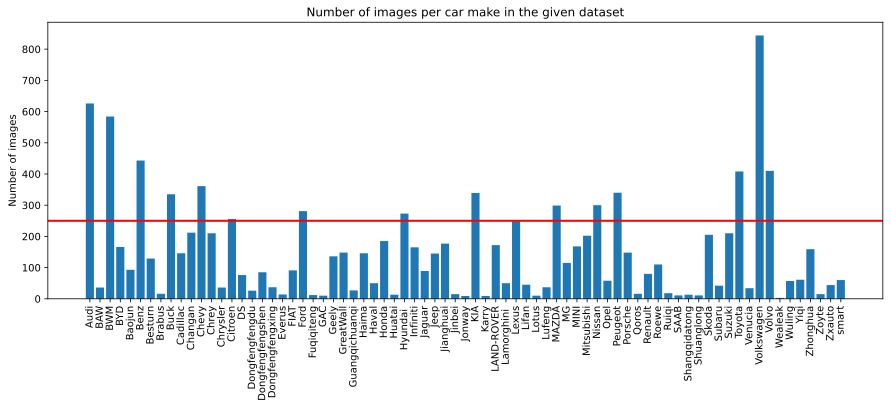

Counter({73: 844, 78: 626, 81: 584, 77: 443, 111: 410, 39: 408, 157: 361, 102: 340, 140: 339, 54: 335, 97: 300, 162: 299, 122: 281, 118: 273, 158: 256, 159: 249, 152: 212, 149: 210, 75: 210, 95: 205, 28: 202, 100: 185, 108: 177, 142: 172, 15: 168, 105: 166, 131: 165, 38: 159, 48: 148, 150: 148, 53: 146, 114: 146, 11: 145, 69: 136, 76: 129, 14: 115, 132: 110, 82: 93, 134: 91, 92: 89, 35: 85, 160: 80, 4: 76, 27: 61, 26: 60, 103: 58, 43: 57, 71: 50, 51: 50, 55: 45, 37: 44, 94: 42, 36: 37, 155: 37, 58: 36, 50: 36, 70: 34, 87: 27, 34: 26, 120: 18, 138: 16, 84: 16, 45: 15, 148: 15, 119: 14, 29: 13, 64: 13, 121: 12, 68: 11, 128: 11, 88: 10, 133: 10, 106: 9, 89: 9, 80: 3})


In [9]:
############################################################
# Function to count the number of images per car make
############################################################

THRESH_AUGMENT = 250

def count_labels(dataset, make = True):
	# Extracts the labels from the dataset
	if make:
		list = [make for _, make, _ in dataset]
	else:
		list = [model for _, _, model in dataset]

	# Counts the occurrences of each label
	dataset_count = Counter(list)

	# Transform the labels into the string using get_names function
	if make:
		dataCount_names = {tuple(get_names(mat_file, [label, 0]))[0]: count for label, count in tqdm(dataset_count.items())}
	else:
		dataCount_names = {tuple(get_names(mat_file, [0, label]))[1]: count for label, count in tqdm(dataset_count.items())}

	# Print the labels and their counts
	print("Dataset labels:", dataCount_names)

	# Sort the labels by alphabetical order
	sorted_labels = sorted(dataCount_names.items(), key=lambda x: x[0])
	labels, counts = zip(*sorted_labels)

	# Create the plot
	plt.figure(figsize=(15, 5))
	plt.axhline(y=THRESH_AUGMENT, color='r', linestyle='-', label='Threshold for augmentation')
	plt.bar(labels, counts)
	plt.xticks(rotation=90)
	plt.ylabel("Number of images")
	plt.title("Number of images per car make in the given dataset")
	plt.show()

	return dataset_count

train_counts = count_labels(train_dataset)
print(train_counts)

As you can see by the plot, the dataset is imbalanced.  
We will now augment to 400 samples the labels with less than 250 samples 

In [10]:
# Augment the training dataset
# Define the target classes and the number of new samples to generate depending on the number of existing samples in train_counts
# The target classes are the car makes with the least number of samples

target_classes = [label for label, count in train_counts.items() if count < THRESH_AUGMENT]
print("Target classes:", target_classes)
num_new_samples = 400
augmented_dataset = AugmentedDataset(train_dataset, target_classes, num_new_samples, transform1, normalize)

# Test the augmentation
print("Original dataset size:", len(train_dataset))
print("Augmented dataset size:", len(augmented_dataset))

Target classes: [152, 53, 114, 43, 149, 132, 159, 142, 48, 108, 76, 134, 71, 35, 69, 150, 87, 100, 75, 15, 27, 14, 37, 82, 55, 38, 36, 131, 11, 4, 92, 28, 138, 58, 103, 160, 95, 50, 105, 51, 94, 34, 26, 120, 29, 155, 45, 119, 70, 68, 106, 148, 88, 89, 121, 80, 84, 133, 64, 128]


  0%|          | 0/11211 [00:00<?, ?it/s]

Label found for class 152
Number of existing samples for class 152 : 212
Label found for class 53
Number of existing samples for class 53 : 146
Label found for class 114
Number of existing samples for class 114 : 146
Label found for class 43
Number of existing samples for class 43 : 57
Label found for class 149
Number of existing samples for class 149 : 210
Label found for class 132
Number of existing samples for class 132 : 110
Label found for class 159
Number of existing samples for class 159 : 249
Label found for class 142
Number of existing samples for class 142 : 172
Label found for class 48
Number of existing samples for class 48 : 148
Label found for class 108
Number of existing samples for class 108 : 177
Label found for class 76
Number of existing samples for class 76 : 129
Label found for class 134
Number of existing samples for class 134 : 91
Label found for class 71
Number of existing samples for class 71 : 50
Label found for class 35
Number of existing samples for class 35

#### Let's now plot the samples distribution 

  0%|          | 0/75 [00:00<?, ?it/s]

Dataset labels: {'Audi': 626, 'MAZDA': 299, 'Changan': 400, 'Benz': 443, 'Cadillac': 400, 'Toyota': 408, 'Haima': 400, 'Citroen': 256, 'BWM': 584, 'Wuling': 400, 'KIA': 339, 'Ford': 281, 'Hyundai ': 273, 'Suzuki': 400, 'Roewe': 400, 'Peugeot': 340, 'Lexus': 400, 'LAND-ROVER': 400, 'Porsche': 400, 'Volkswagen': 844, 'Jianghuai': 400, 'Besturn': 400, 'FIAT': 400, 'Buck': 335, 'Haval': 400, 'Dongfengfengshen': 400, 'Geely': 400, 'Volvo': 410, 'Chevy': 361, 'GreatWall': 400, 'Guangqichuanqi': 400, 'Honda': 400, 'Chrey': 400, 'MINI': 400, 'Yiqi': 400, 'Nissan': 300, 'MG': 400, 'Zxauto': 400, 'Baojun': 400, 'Lifan': 400, 'Zhonghua': 400, 'Dongfengfengxing': 400, 'Infiniti': 400, 'Jeep': 400, 'DS': 400, 'Jaguar': 400, 'Mitsubishi': 400, 'Qoros': 400, 'BAW': 400, 'Opel': 400, 'Renault': 400, 'Skoda': 400, 'Chrysler': 400, 'BYD': 400, 'Lamorghini ': 400, 'Subaru': 400, 'Dongfengfengdu': 400, 'smart': 400, 'Ruiqi': 400, 'Shangqidatong': 400, 'Lufeng': 400, 'Zoyte': 400, 'Everus': 400, 'Venucia':

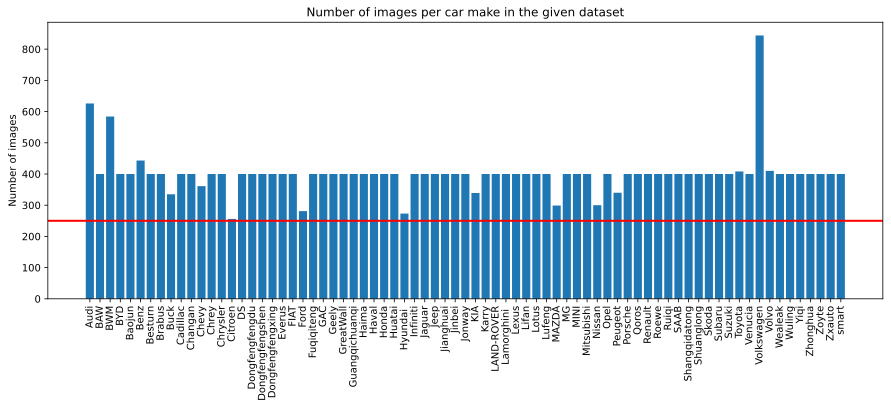

Counter({73: 844, 78: 626, 81: 584, 77: 443, 111: 410, 39: 408, 152: 400, 53: 400, 114: 400, 43: 400, 149: 400, 132: 400, 159: 400, 142: 400, 48: 400, 108: 400, 76: 400, 134: 400, 71: 400, 35: 400, 69: 400, 150: 400, 87: 400, 100: 400, 75: 400, 15: 400, 27: 400, 14: 400, 37: 400, 82: 400, 55: 400, 38: 400, 36: 400, 131: 400, 11: 400, 4: 400, 92: 400, 28: 400, 138: 400, 58: 400, 103: 400, 160: 400, 95: 400, 50: 400, 105: 400, 51: 400, 94: 400, 34: 400, 26: 400, 120: 400, 29: 400, 155: 400, 45: 400, 119: 400, 70: 400, 68: 400, 106: 400, 148: 400, 88: 400, 89: 400, 121: 400, 80: 400, 84: 400, 133: 400, 64: 400, 128: 400, 157: 361, 102: 340, 140: 339, 54: 335, 97: 300, 162: 299, 122: 281, 118: 273, 158: 256})


In [11]:
#Let's check the number of images per car make in the augmented dataset
augmented_counts = count_labels(augmented_dataset)
print(augmented_counts)

Now the classes are balanced, except for the Volkswagen class.  
We could randomly reduce its samples to bring the number of samples per class to around 400.  
However, this approach risks losing entire car models (which are more numerous in the Volkswagen class), leading to poorer learning.  
Therefore, we will keep this class with more samples than the others, introducing a slight bias in learning but preserving knowledge of the models.  

Now we can apply the base_transform on the validation set

In [12]:
# Apply the transformation to each image in the validation dataset
val_dataset = [(normalize((val_dataset[i][0])), val_dataset[i][1], val_dataset[i][2]) for i in tqdm(range(len(val_dataset)))]

  0%|          | 0/4805 [00:00<?, ?it/s]

### Dataloaders  
Load the data and split it into the maximum number of batch_size that the machine can handle.  

In [13]:
# Create the data loaders
train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

### Test  
Let's see how the images are transformed, the img shape and the size of all the sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4768373..2.1229997].


Make: 48
Model: 326
Image shape: torch.Size([3, 224, 224])


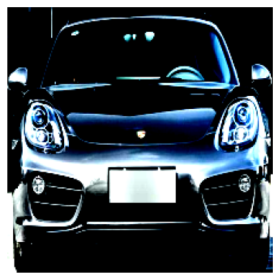

('Porsche', 'Cayman')
Number of images in the training set: 30099
Number of images in the validation set: 4805
Number of images in the test set: 14939


In [14]:
# Function to denormalize images
def denormalize(img, mean, std):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
	img = img.numpy()  # Convert tensor to numpy array
	img = np.transpose(img, (1, 2, 0))  # Transpose to (height, width, channels)
	plt.imshow(img)
	plt.axis('off')
	plt.show()

# Find the dataset index for label 138
# for i, (img, make, model) in enumerate(augmented_dataset):
#     if make == 64:
#         img, car_make, car_model = augmented_dataset[i]
#         img = denormalize(img.clone(), mean, std)
#         imshow(img)

img, car_make, car_model = augmented_dataset[27]

print("Make:", car_make)
print("Model:", car_model)
print("Image shape:", img.shape)

# Display the image
#img = denormalize(img.clone(), mean, std)
imshow(img)

# for i, (img_batch, car_make_batch, car_model_batch) in enumerate(augmented_dataset):
#     print(i)
#     print(img_batch.shape)
#     print(car_make_batch)
#     print(car_model_batch)
#     break

print(get_names(mat_file, [car_make, car_model]))

print("Number of images in the training set:", len(augmented_dataset))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))

# Model

Let's create the models we will use.  
In this project we will train and test 2 different models to see which one is better:  
##### ResNet50

**RestNet50**
The identity block is the standard block used in ResNets, and corresponds to the case where the input activation has the same dimension as the output activation. Here, we implement an identity block in which the skip connection skips over 3 hidden layers.

In [15]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up.

In [16]:
class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

**Building the ResNet model (50 layers)**
Below we implement the ResNet50 model.
The input of the Linear layer is the output of the previous layer which we can compute with this formula: O = ((d-F+2p) /s) +1

In [17]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class CustomResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(8192, 163) #163 is the number of classes (car makes) we are classifying in this project
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


### Loss to solve class imbalance

In [18]:
class FocalLoss(nnpo.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        # Compute the Cross Entropy Loss
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

#### Early stopping implementation
It is done to stop the training loop whenever the validation loss grows  
It has a patience term to see if after some iterations the validation loss lowers again

In [19]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta*self.best_loss: #If the validation loss is higher than the best loss plus delta percent of the best loss
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Training...

#### Setting the model parameters and load possible past model

In [ ]:
from torch.nn import CrossEntropyLoss
from torchmetrics.functional import accuracy

# Assuming the model, train_loader, and val_loader are already defined
model = CustomResNet50()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = CrossEntropyLoss()
#loss_fn = FocalLoss(alpha=1, gamma=2, reduce=True)
model.to(device)
epochs = 20
best_val = np.inf
check_name = "FINAL_MODEL"
checkpoint_path = check_name +".pt"	# Path to save the model

# Define the early stopping callback
early_stopping = EarlyStopping(patience=5, delta=0.05)

# Load the model if it exists
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model loaded", checkpoint_path)
else:
	print("Model not found, creating a new one")



Model not found, creating a new one


## Train-val loop

In [21]:
# Lists to store the loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []
top1_accuracies = []
top5_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    train_loss = 0
    train_predictions = []
    iterator = tqdm(train_loader)
    all_batch_y = []
    for batch_x, batch_y, _ in iterator:  # ignoring the third value with _
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        all_batch_y.append(batch_y)

        y_pred = model(batch_x)
        train_predictions.append(y_pred)	# Save the predictions for the epoch

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.detach().cpu().numpy()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    train_loss /= len(train_loader)  # Average training loss for the epoch
    train_losses.append(train_loss)
    train_predictions = torch.cat(train_predictions, axis=0)
    all_batch_y = torch.cat(all_batch_y, axis=0)
    train_acc = accuracy(preds=train_predictions, target=all_batch_y, task='multiclass', num_classes=163, top_k=1)
    print(f"Average Training loss: {train_loss}, Training accuracy: {train_acc}")

    # Validation loop
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y, _ in tqdm(val_loader):  # ignoring the third value
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)

        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)

        val_loss = loss_fn(predictions, true)

        val_losses.append(val_loss.item())
        top1_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=1)
        top5_accu = accuracy(preds=predictions, target=true,task='multiclass',num_classes= 163, top_k=5)
        top1_accuracies.append(top1_accu.item())
        top5_accuracies.append(top5_accu.item())

        print(f"Validation loss: {val_loss}, Validation accuracy: TOP1 accuracy: {top1_accu}, TOP5 accuracy: {top5_accu}")

    # Save the model if the validation loss improves
    if val_loss < best_val:
        print("-----------Saved Model---------------")
        torch.save(model.state_dict(), checkpoint_path)
        best_val = val_loss
        print("#####################################")

	# Check for early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("///////////Early stopping////////////")
        break

Epoch: 1


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 4.668588429277685, Training accuracy: 0.06252699345350266


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 4.717193126678467, Validation accuracy: TOP1 accuracy: 0.06847034394741058, TOP5 accuracy: 0.2742975950241089
-----------Saved Model---------------
#####################################
Epoch: 2


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 3.1832670235608513, Training accuracy: 0.2330642193555832


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.7016308307647705, Validation accuracy: TOP1 accuracy: 0.09802289307117462, TOP5 accuracy: 0.32570239901542664
-----------Saved Model---------------
#####################################
Epoch: 3


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 2.433474315847018, Training accuracy: 0.38798630237579346


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.6571624279022217, Validation accuracy: TOP1 accuracy: 0.14318418502807617, TOP5 accuracy: 0.40104058384895325
-----------Saved Model---------------
#####################################
Epoch: 4


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 1.9743067531605962, Training accuracy: 0.4897505044937134


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.8798317909240723, Validation accuracy: TOP1 accuracy: 0.1610822081565857, TOP5 accuracy: 0.44432881474494934
Epoch: 5


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 1.5566586423883022, Training accuracy: 0.5845709443092346


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.1644625663757324, Validation accuracy: TOP1 accuracy: 0.2507804334163666, TOP5 accuracy: 0.5433923006057739
-----------Saved Model---------------
#####################################
Epoch: 6


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 1.2306437201314981, Training accuracy: 0.6602877378463745


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.098051071166992, Validation accuracy: TOP1 accuracy: 0.2788761854171753, TOP5 accuracy: 0.5771071910858154
-----------Saved Model---------------
#####################################
Epoch: 7


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.9146467708565857, Training accuracy: 0.7420512437820435


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 2.8856425285339355, Validation accuracy: TOP1 accuracy: 0.31758585572242737, TOP5 accuracy: 0.6293444037437439
-----------Saved Model---------------
#####################################
Epoch: 8


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.7187897731707402, Training accuracy: 0.7912887334823608


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.0583298206329346, Validation accuracy: TOP1 accuracy: 0.3213319480419159, TOP5 accuracy: 0.6314256191253662
Epoch: 9


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.5432355345308971, Training accuracy: 0.8396624326705933


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.1353330612182617, Validation accuracy: TOP1 accuracy: 0.33798128366470337, TOP5 accuracy: 0.6445369124412537
Epoch: 10


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.42388108527479845, Training accuracy: 0.8721552491188049


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 4.327484130859375, Validation accuracy: TOP1 accuracy: 0.3544224798679352, TOP5 accuracy: 0.6464099884033203
Epoch: 11


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.33150924603265736, Training accuracy: 0.900926947593689


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 4.4513936042785645, Validation accuracy: TOP1 accuracy: 0.35796046257019043, TOP5 accuracy: 0.6530697345733643
Epoch: 12


  0%|          | 0/941 [00:00<?, ?it/s]

Average Training loss: 0.27843008369729955, Training accuracy: 0.9171068668365479


  0%|          | 0/151 [00:00<?, ?it/s]

Validation loss: 3.3522350788116455, Validation accuracy: TOP1 accuracy: 0.37023934721946716, TOP5 accuracy: 0.6663891673088074
///////////Early stopping////////////


#### Saving the results
Saving the results it's important to access to them even later and continue the training from the point we left

In [22]:
# Function to append values to a file
def append_to_file(file_name, values):
    try:
        # If the file does not exist, create it
        if not os.path.exists(file_name):
            # Create the empty file
            os.makedirs(os.path.dirname(file_name), exist_ok=True)

        with open(file_name, "a") as f:
            f.write(",".join(str(value) for value in values))
            f.write(",")  # Add a comma to separate the values
    except Exception as e:
        print(f"Error during the reading of file {file_name}: {e}")

# function to read values from a file
def read_from_file(file_path):
    values = []  # Empty list to store the values
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line and filter out empty strings before converting to float
                values.extend(map(float, filter(None, line.strip().split(','))))
    except Exception as e:
        print(f"Error during the reading {e}")
    return values

In [23]:
# Save the top1, top5 and train - validation loss values in a text file
top1_path = os.path.join(check_name , "top1_accuracies.txt")
top5_path = os.path.join(check_name , "top5_accuracies.txt")
val_loss_path = os.path.join(check_name , "val_losses.txt")
train_loss_path = os.path.join(check_name , "train_losses.txt")

print("Saving the accuracies and losses...")
append_to_file(top1_path, top1_accuracies)
append_to_file(top5_path, top5_accuracies)
append_to_file(val_loss_path, val_losses)
append_to_file(train_loss_path, train_losses)
print("Done!")

Saving the accuracies and losses...
Done!


### Plot

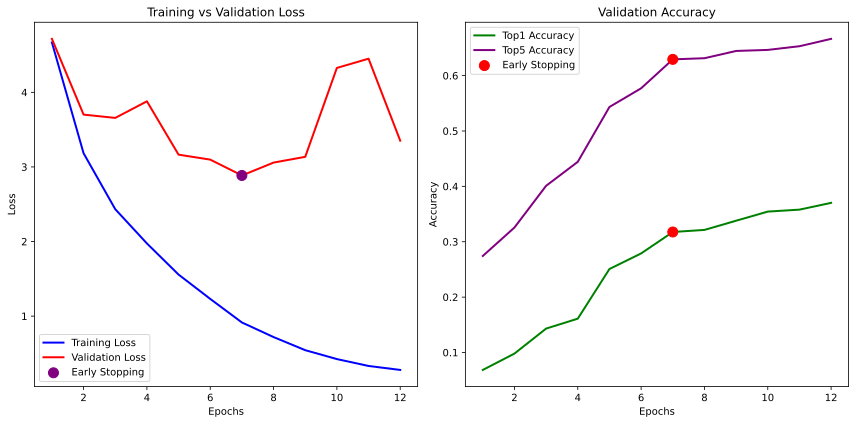

In [24]:
# Plotting the training and validation loss/accuracy curves

# Reading the saved values from the text file
train_losses = read_from_file(train_loss_path)
val_losses = read_from_file(val_loss_path)
top1_accuracies = read_from_file(top1_path)
top5_accuracies = read_from_file(top5_path)

epochs_range = range(1, len(train_losses) + 1)
best_epoch = np.argmin(val_losses) + 1

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", color='red')
# Highlight the best epoch
plt.scatter(best_epoch, val_losses[best_epoch-1], color='purple', s=100, zorder=5, label='Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, top1_accuracies, label="Top1 Accuracy", color='green')
plt.plot(epochs_range, top5_accuracies, label="Top5 Accuracy", color='purple')
# Highlight the best epoch
plt.scatter(best_epoch, top1_accuracies[best_epoch-1], color='red', s=100, zorder=5, label='Early Stopping')
plt.scatter(best_epoch, top5_accuracies[best_epoch-1], color='red', s=100, zorder=5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# Save the plot
plot_path = os.path.join(check_name , "plot.png")
plt.savefig(plot_path)

plt.tight_layout()
plt.show()

### Here you can load directly the trained weights to test their performance

In [ ]:
###############################
# load previous saved model
###############################

# Load the model if it exists
if os.path.exists(checkpoint_path):
	model = CustomResNet50()  # Ensure the model architecture matches
	model.load_state_dict(torch.load(checkpoint_path))
	print("Model loaded successfully!",checkpoint_path)

C:\Users\giuse\AppData\Local\Temp\ipykernel_48108\739849778.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model loaded successfully! AUGMENTED_with_Cross_Entropy.pt


# Test loop

In [26]:
# Test loop
model.eval()
model.to(device)	# Ensure the model is on the same device as the input
test_loss = 0
test_acc = 0
with torch.no_grad():
	test_predictions = []
	test_true = []
	for batch_x, batch_y, _ in tqdm(test_loader):  # ignoring the third value
		batch_x = batch_x.to(device)
		batch_y = batch_y.to(device)

		y_pred = model(batch_x)

		test_predictions.append(y_pred)
		test_true.append(batch_y)
		#print some random images and their predictions

		########## UNCOMMENT TO PRINT SOME RANDOM IMAGES AND THEIR PREDICTIONS ##########
		# if random.random() < 0.01:
		# 	_, preds = torch.max(y_pred, 1)
		# 	print("Predictions:", preds)
		# 	print("True labels:", batch_y)

	test_predictions = torch.cat(test_predictions, axis=0)
	test_true = torch.cat(test_true, axis=0)

	test_loss = loss_fn(test_predictions, test_true).detach().cpu().numpy()
	test_acc = (test_predictions.argmax(dim=1) == test_true).float().mean()
	test_true = test_true.detach().cpu().numpy()
	test_predictions = test_predictions.detach().cpu()

  0%|          | 0/467 [00:00<?, ?it/s]

In [27]:
from torchmetrics.functional import accuracy

top1_accu = accuracy(test_predictions, torch.tensor(test_true), task='multiclass', num_classes=163, top_k=1)
top5_accu = accuracy(test_predictions, torch.tensor(test_true), task='multiclass', num_classes=163, top_k=5)

print(f"loss: {test_loss}, TOP1 accuracy: {top1_accu}, TOP5 accuracy: {top5_accu}")

loss: 2.830214023590088, TOP1 accuracy: 0.3261931836605072, TOP5 accuracy: 0.6341120600700378


## Testing  
Here, the model's performance can be tested by randomly selecting an image from the test set and having the network classify it.

Path: .\Deep_Project\data\cropped_image\classification\test\81\89\2009\5bf9dddb350924.jpg
Make: 81
Model: 89
('BWM', 'BWM 3 Series coupe')
Prediction: 162 (' MAZDA ')


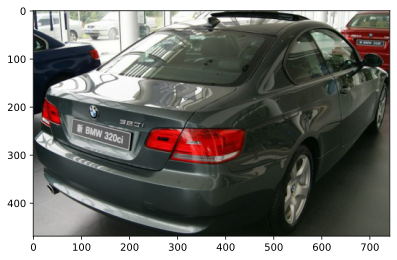

In [124]:
# Load the image
random_number = random.randint(0, len(test_dataset) - 1)
img, car_make, car_model = test_dataset[random_number]
path = os.path.join(test_path, str(car_make), str(car_model))
path = os.path.join(path, os.listdir(path)[0])   #year pick the first year available
path = os.path.join(path, os.listdir(path)[0])	#image pick the first image
print("Path:", path)

# Show the image
image = Image.open(path).convert("RGB")
plt.imshow(image)
print("Make:", car_make)
print("Model:", car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
img = img.unsqueeze(0).to(device)  # Add a batch dimension and move the image to the device
model.to(device)  # Ensure the model is on the same device as the input
pred = model(img).argmax(dim=1).item()
print("Prediction:", pred, "('", get_names(mat_file, [pred, 0])[0],"')")  # Get the name of the predicted class, we are only predicting the make of the car

As you can see, the model no longer outputs only the same 3–4 most common labels but also correctly predicts those with fewer samples.  
However, the overall accuracy on the entire dataset, especially for the most common labels, has decreased to better recognize the less represented ones.  
